This notebook compares the results of the GA and MILP optimization.
It generates maps to analyze the spatial distribution of the selected stations.

---
Author: Jordi Grau Escolano


# 1. Load data

In [57]:
import sys
import ast
from pathlib import Path
from shapely import wkt  # type: ignore
import pandas as pd  # type: ignore
import geopandas as gpd  # type: ignore
import matplotlib.pyplot as plt  # type: ignore
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable  # type: ignore
import contextily as ctx  # type: ignore

# Add project root to path
project_root = Path().resolve().parents[0]
sys.path.insert(0, str(project_root))
print(project_root)

from paths import *
import src.data_loader as dl
import src.optimization.helper_optimization as oh


ROOT = ".."
EPSG = 25831
STATION_MIN_DISTANCE = 300

# Load node attributes and geometries
file = f'{ROOT}/{PR_NODES}/normalized_node_attributes.csv'
df = pd.read_csv(file)
df['geometry'] = df['geometry'].apply(wkt.loads)
df = gpd.GeoDataFrame(df, geometry='geometry', crs=EPSG)


# Load optimization results 
file_ga = pd.read_csv(f'{ROOT}/{PR_EXP}/GA_MILP_weights/GA_results.csv')
file_lp = pd.read_csv(f'{ROOT}/{PR_EXP}/GA_MILP_weights/MILP_results.csv')
df_ga = pd.DataFrame(file_ga)[['experiment_idx', 'N_stations', 'best_score', 'minutes_to_complete',  'weights', 'best_solution']]
df_lp = pd.DataFrame(file_lp)[['experiment_idx', 'N_stations', 'best_score', 'minutes_to_complete', 'weights', 'best_solution']]

rename_columns = {
    'minutes_to_complete': 'time', 
    'experiment_idx': 'execution_id', 
    'best_solution': 'solution',
    'best_score': 'score'
}

# Parse weights
def parse_weights(weights_str):
    weights = ast.literal_eval(weights_str)
    return {k.strip(): float(v) for k, v in [item.split(':') for item in weights]}

for df in [df_ga, df_lp]:
    df.rename(columns=rename_columns, inplace=True)
    df['time'] = df['time'] / 60 # to minutes

# Merge data
df_scores = pd.merge(df_ga, df_lp, on=['execution_id', 'N_stations', 'weights'], suffixes=('_ga', '_lp'), how='outer')

# Convert string representation of lists to actual lists
df_scores['weights'] = df_scores['weights'].apply(parse_weights)
df_scores['solution_ga'] = df_scores['solution_ga'].fillna('[]').astype(str).str.strip('[]').str.split(',').apply(lambda x: [int(node.strip()) for node in x if node.strip()])
df_scores['solution_lp'] = df_scores['solution_lp'].str.strip('[]').str.split(',').apply(lambda x: [int(node.strip()) for node in x])
df_scores.dropna(inplace=True)

df_scores.head(2)

/home


,execution_id,N_stations,score_ga,time_ga,weights,solution_ga,score_lp,time_lp,solution_lp
0,1,60,53.107040,0.563388,"{'10-19': 0.0032612055617122315, '20-29': 0.04...","[979671206, 8091274334, 8091274335, 979671154,...",53.423520,0.097633,"[2044165018, 10893194529, 534390962, 403787665..."
1,2,60,53.168809,0.470871,"{'10-19': 0.03489456438290895, '20-29': 0.0164...","[979671206, 979671154, 11498165028, 979671188,...",53.349043,0.097390,"[2044165018, 625357944, 10893194529, 534390962..."


# 2. Comparison map

In [54]:
def plot_all_weight_comparison(
    gdf, 
    N_STATIONS, 
    weights_collection, 
    best_nodes_MILP_collection, 
    best_scores_MILP_collection, 
    best_nodes_ga_collection, 
    best_scores_ga_collection,
    ga_experiment_strs=None,
    STATION_MIN_DISTANCE=0
):
    """
    Plot a comparison of node scores, greedy algorithm, and genetic algorithm results
    for multiple weight combinations.
    
    Args:
        gdf (GeoDataFrame): GeoDataFrame with node scores.
        N_STATIONS (int): Number of stations.
        weights_collection (list): List of weight dictionaries.
        best_nodes_greedy_collection (list): List of node ID lists selected by greedy algorithm for each weight.
        best_scores_greedy_collection (list): List of score lists for nodes selected by greedy algorithm for each weight.
        best_nodes_ga_collection (list): List of node ID lists selected by genetic algorithm for each weight.
        best_scores_ga_collection (list): List of score lists for nodes selected by genetic algorithm for each weight.
        ga_experiment_strs (list, optional): List of strings describing GA experiment parameters for each weight.
        STATION_MIN_DISTANCE (float): Minimum distance between stations. If 0, no distance constraint is applied.
    """
    # Number of weight combinations to display
    n_weights = len(weights_collection)
    
    # Create a figure with n_weights rows and 3 columns (all nodes, greedy, GA)
    fig = plt.figure(figsize=(15, 6 * n_weights))
    
    # Create a grid layout
    gs = fig.add_gridspec(n_weights, 3)
    
    # Load Barcelona boundary
    bcn_boundary = dl.load_bcn_boundary()
    
    # Settings
    markersize = 0.5
    fontsize_title = 9
    nodes_scores_fontsize = 7
    cmap = plt.cm.viridis
    
    # For each weight combination
    for w_idx, (weights, best_nodes_greedy, best_scores_greedy, best_nodes_ga, best_scores_ga) in enumerate(
        zip(weights_collection, best_nodes_MILP_collection, best_scores_MILP_collection, 
            best_nodes_ga_collection, best_scores_ga_collection)
    ):
        # Compute scores for this weight combination
        gdf_weighted = oh.sum_and_normalize_all_node_scores(gdf.copy().reset_index(), weights)
        
        # Create axes for this row
        ax_all_nodes = fig.add_subplot(gs[w_idx, 0])
        ax_greedy = fig.add_subplot(gs[w_idx, 1])
        ax_ga = fig.add_subplot(gs[w_idx, 2])
        
        # Column 1: All nodes score map
        scatter = gdf_weighted.plot(
            column='norm_score',
            cmap=cmap,
            ax=ax_all_nodes,
            markersize=markersize,
            legend=False,
            vmin=0, vmax=1)
        
        # Add colorbar inside the plot
        divider = make_axes_locatable(ax_all_nodes)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        cbar = plt.colorbar(scatter.collections[0], cax=cax)
        cbar.ax.tick_params(labelsize=8)
        original_min, original_max = gdf_weighted["score"].min(), gdf_weighted["score"].max()
        cbar.ax.set_ylabel(f'Score (min={original_min:.2f}, max={original_max:.2f})', fontsize=8)
        
        # Column 2: Greedy algorithm without distance constraint
        if best_nodes_greedy:
            scatter = gdf_weighted.loc[best_nodes_greedy].plot(
                column='norm_score', 
                ax=ax_greedy, 
                markersize=markersize*10, 
                cmap=cmap, 
                label='BSS stations', 
                vmin=0, vmax=1)
        
        # Column 3: Genetic algorithm with distance constraint determined by STATION_MIN_DISTANCE
        if best_nodes_ga:
            scatter = gdf_weighted.loc[best_nodes_ga].plot(
                column='norm_score', 
                ax=ax_ga, 
                markersize=markersize*10,
                cmap=cmap,
                label='BSS stations',
                vmin=0, vmax=1)
        
        # Add Barcelona boundary to all plots
        bcn_boundary.boundary.plot(ax=ax_all_nodes, edgecolor='black', linewidth=1)
        bcn_boundary.boundary.plot(ax=ax_greedy, edgecolor='black', linewidth=1)
        bcn_boundary.boundary.plot(ax=ax_ga, edgecolor='black', linewidth=1)
        
        # Add best nodes text to the plots
        if best_nodes_greedy:
            nodes_scores_greedy = gdf_weighted.loc[best_nodes_greedy]['norm_score'].head(20)
            nodes_scores_greedy.index.name = ''
            nodes_scores_greedy.name = ''
            
            # Convert Series to string representation
            greedy_text = '\n'.join([f"{idx}: {val:.4f}" for idx, val in nodes_scores_greedy.items()])
            
            ax_greedy.text(
                0.01, 0.99, greedy_text,
                ha='left', va='top', fontsize=nodes_scores_fontsize, color='black',
                transform=ax_greedy.transAxes
            )
        
        if best_nodes_ga:
            nodes_scores_ga = gdf_weighted.loc[best_nodes_ga]['norm_score'].head(20)
            nodes_scores_ga.index.name = ''
            nodes_scores_ga.name = ''
            
            # Convert Series to string representation
            ga_text = '\n'.join([f"{idx}: {val:.4f}" for idx, val in nodes_scores_ga.items()])
            
            ax_ga.text(
                0.01, 0.99, ga_text,
                ha='left', va='top', fontsize=nodes_scores_fontsize, color='black',
                transform=ax_ga.transAxes
            )
        
        # Add basemap to all plots
        ctx.add_basemap(ax_all_nodes, source=ctx.providers.CartoDB.Positron, crs=gdf.crs.to_string(), zoom=12)
        ctx.add_basemap(ax_greedy, source=ctx.providers.CartoDB.Positron, crs=gdf.crs.to_string(), zoom=12)
        ctx.add_basemap(ax_ga, source=ctx.providers.CartoDB.Positron, crs=gdf.crs.to_string(), zoom=12)
        
        # Titles
        weights_str = ', '.join([f'{key}: {value}' for key, value in weights.items() if value != 0])
        if len(weights_str) > 70:
            weights_list = [f'{key}: {value}' for key, value in weights.items() if value != 0]
            weights_str = '\n'.join(weights_list)
        
        greedy_score = sum(best_scores_greedy) if isinstance(best_scores_greedy, list) else best_scores_greedy
        ga_score = sum(best_scores_ga) if isinstance(best_scores_ga, list) else best_scores_ga
        
        # ax_all_nodes.set_title(f"{weights_str}", fontsize=fontsize_title)
        ax_greedy.set_title(f"MILP ({STATION_MIN_DISTANCE}m dist.) -> Score: {greedy_score:.3f}", fontsize=fontsize_title)
        
        if ga_experiment_strs and w_idx < len(ga_experiment_strs):
            ga_title = f"GA ({STATION_MIN_DISTANCE}m dist.) -> Score: {ga_score:.3f}"
        else:
            ga_title = f"GA ({STATION_MIN_DISTANCE}m dist.) -> Score: {ga_score:.3f}"
            
        ax_ga.set_title(ga_title, fontsize=fontsize_title)
        
        # Turn off axis
        ax_all_nodes.set_axis_off()
        ax_greedy.set_axis_off()
        ax_ga.set_axis_off()
    
    plt.tight_layout()
    
    plt.show()

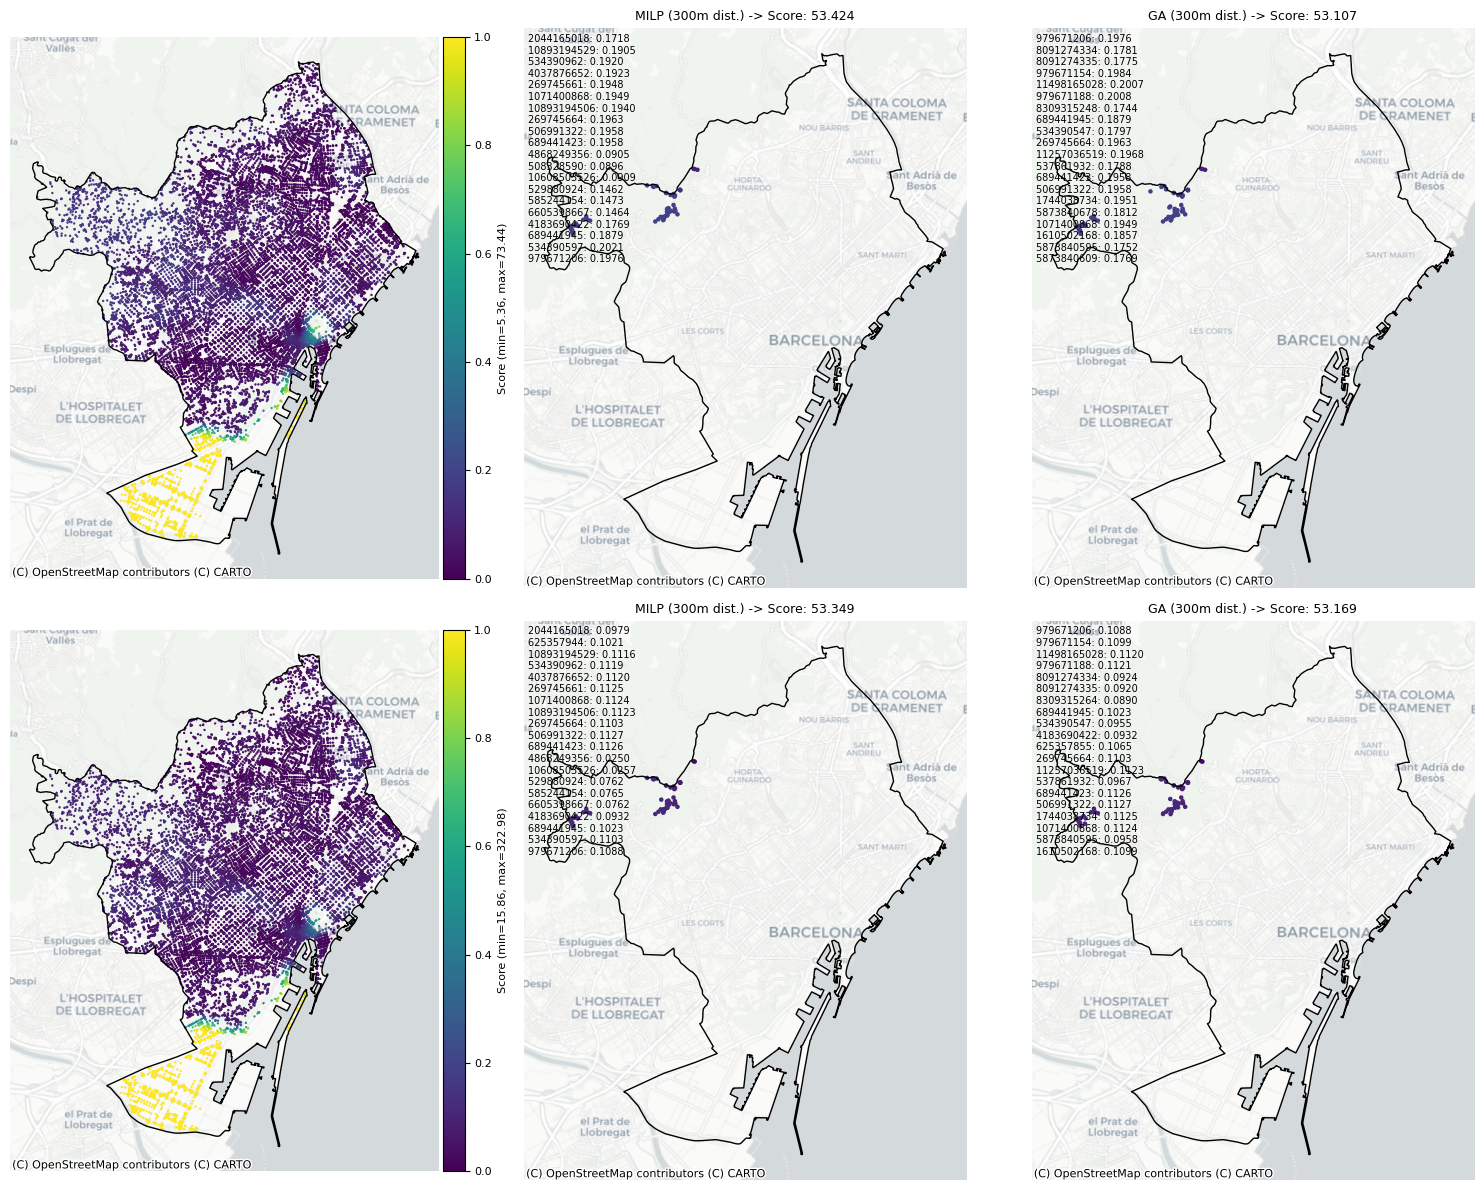

In [56]:
example_df = df_scores.head(2)
plot_all_weight_comparison(
    df.set_index('node_id'), 
    N_STATIONS=60, 
    weights_collection=example_df['weights'],
    best_nodes_MILP_collection=example_df['solution_lp'],
    best_scores_MILP_collection=example_df['score_lp'],
    best_nodes_ga_collection=example_df['solution_ga'],
    best_scores_ga_collection=example_df['score_ga'],
    ga_experiment_strs="Weights",
    STATION_MIN_DISTANCE=STATION_MIN_DISTANCE
)